In [1]:
import numpy as np
# next we assume these values of TIME and N_STEPS for all the codes 
N_STEPS = 99
# since the calibration dosn't depend on time
# we can chose different time for evolution and calibration.
# we explain it in mitigation chapter.
TIME = np.pi
CALIBRATION_TIME = np.pi

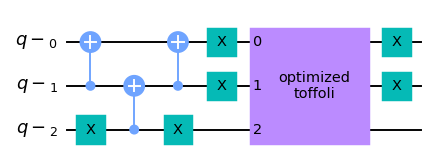

In [25]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.circuit import Parameter
from lib import utilities
from lib.utilities import B, state_permutations_B
import copy
from qiskit.ignis.verification.tomography import StateTomographyFitter
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.quantum_info import state_fidelity
from qiskit.opflow import One, Zero
# built the permutation operator and the matrix associated to this circuit
B_qr=QuantumRegister(3, name="q-")
B_qc=QuantumCircuit(B_qr, name="B")
B_qc.x(B_qr[2])
B_qc.cx(B_qr[1],B_qr[0])
B_qc.cx(B_qr[2],B_qr[1])
B_qc.cx(B_qr[1],B_qr[0])
B_qc.x([B_qr[0],B_qr[1],B_qr[2]])
B_qc.append(utilities.Toffoli_gate,[B_qr[0],B_qr[1],B_qr[2]])
B_qc.x([B_qr[0],B_qr[1]])

B_qc.draw(output="mpl", style={"figwidth":6, "fontsize":15})

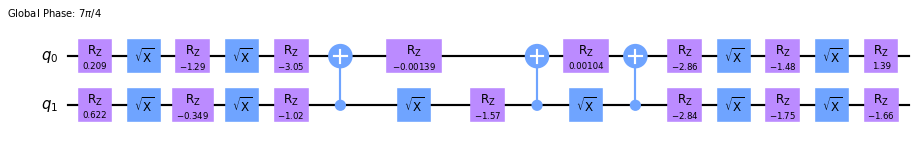

In [26]:
# The matrix D is a block of B' T B
# To avoid code redundancy, we defined the trotter operation 
# in the external script utilities.py

T = utilities.trotterized_matrix(TIME, N_STEPS)
T_b = np.linalg.multi_dot([ B, T, B.transpose() ])

D = T_b[0:4, 0:4]

from qiskit import transpile
# Transpile the D operator and build the evolution circuit
D_qc = QuantumCircuit(2, name="D")
D_qc.unitary(D,[0,1])    
D_qc = transpile(D_qc, basis_gates=['cx','x','sx','rz']) # Jackarta basis gates

D_qc.draw(output="mpl", style={"figwidth":13, "fontsize":11})

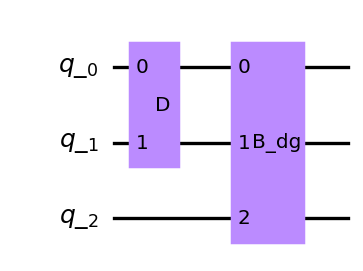

In [27]:
qr_U_best_HSD = QuantumRegister(3, name="q_")
qc_U_best_HSD = QuantumCircuit(qr_U_best_HSD, name="D")
# appending the D gate and the B.dagger permutation
qc_U_best_HSD.append(D_qc, [qr_U_best_HSD[0], qr_U_best_HSD[1]])
qc_U_best_HSD.append(B_qc.inverse(), qr_U_best_HSD)
# hilbert space decomposition evolution circuit
qc_U_best_HSD.draw(output="mpl", style={"figwidth":5, "fontsize":12})

In [28]:
from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

#################################################################
########################################### execute all the jobs
BACKEND = backend_sim_noisy_jakarta
shots = 20000

ibmqfactory.load_account:WARNING:2022-04-25 18:56:47,660: Credentials are already in use. The existing account in the session will be replaced.


In [37]:
######################################################################
## build the calibration circuits for the Hilbert Space Decomposition
calibration_circuit_HSD, _ = utilities.get_evolution_circuit(CALIBRATION_TIME, N_STEPS, method="HSD")
calib_circuits_HSD_NIC = utilities.get_calibration_circuits(calibration_circuit_HSD, method="NIC", eigenvector="111")
calib_circuits_HSD_CIC = utilities.get_calibration_circuits(calibration_circuit_HSD, method="CIC")
# build the tomography circuits for the hilbert space decomposition.
qr_HSD = QuantumRegister(3, name="q_")
qc_HSD = QuantumCircuit(qr_HSD, name="HSD")
# preparing the initial state.
INITIAL_STATE = "001"
target_state = (One^Zero^Zero).to_matrix()

PERMUTATED_INITIAL_STATE = state_permutations_B[INITIAL_STATE]

for qubit in range(3):
    if INITIAL_STATE[::-1][qubit] == "1":
        qc_HSD.x(qr_HSD[qubit])

qc_HSD.append(qc_U_best_HSD, qr_HSD)
# built the tomograpfhy circuits.
qcs_tomo_HSD = state_tomography_circuits(qc_HSD, qr_HSD)

######################################################################
###################################################### execute all
shots = 32000
job_tomo_HSD=execute(qcs_tomo_HSD, BACKEND, shots=shots, initial_layout=[1,3,5])
job_HSD_NIC=execute(calib_circuits_HSD_NIC, backend = BACKEND, shots=shots, initial_layout=[1,3,5])
job_HSD_CIC=execute(calib_circuits_HSD_CIC, backend = BACKEND, shots=shots, initial_layout=[1,3,5])

########################################################################
####################################################### Mitigation
# compute the U_ideal unitary matrix of the circuit.
U_ideal_HSD = utilities.matrix_from_circuit(calibration_circuit_HSD)
# fast_tomography_calibration_MeasFitters returns a list of 27 CompleteMeasFitter objects, one for each tomo basis.
meas_fitters_HSD_NIC = utilities.fast_tomography_calibration_MeasFitters(job_HSD_NIC.result(), method="NIC")
meas_fitters_HSD_CIC = utilities.fast_tomography_calibration_MeasFitters(job_HSD_CIC.result(), method="CIC", U_ideal=U_ideal_HSD)

# compute the mitigated results.
raw_result_HSD = job_tomo_HSD.result()
NIC_result_HSD = copy.deepcopy(raw_result_HSD)
CIC_result_HSD = copy.deepcopy(raw_result_HSD)
for i in range(27):
    new_counts_NIC_HSD = meas_fitters_HSD_NIC[i].filter.apply(raw_result_HSD.get_counts(i), method="least_squares")
    new_counts_CIC_HSD = meas_fitters_HSD_CIC[i].filter.apply(raw_result_HSD.get_counts(i), method="least_squares")
    NIC_result_HSD.results[i].data.counts = new_counts_NIC_HSD
    CIC_result_HSD.results[i].data.counts = new_counts_CIC_HSD

In [38]:
fid_raw_HSD = utilities.fidelity_count(raw_result_HSD, qcs_tomo_HSD, target_state)
fid_NIC_HSD = utilities.fidelity_count(NIC_result_HSD, qcs_tomo_HSD, target_state)
fid_CIC_HSD = utilities.fidelity_count(CIC_result_HSD, qcs_tomo_HSD, target_state)

print("decomposition method: Hilbert Space Decomposition\nevolution time = %.3f pi\nnumber of trotter steps = %d\n"%(TIME/np.pi, N_STEPS))
print(f"fidelity of raw results: {fid_raw_HSD} \nfidelity with NIC method: {fid_NIC_HSD}\nfidelity with CIC method: {fid_CIC_HSD}")

decomposition method: Hilbert Space Decomposition
evolution time = 1.000 pi
number of trotter steps = 99

fidelity of raw results: 0.01671895632135836 
fidelity with NIC method: 0.011801981909536427
fidelity with CIC method: 4.305119511778621e-05
